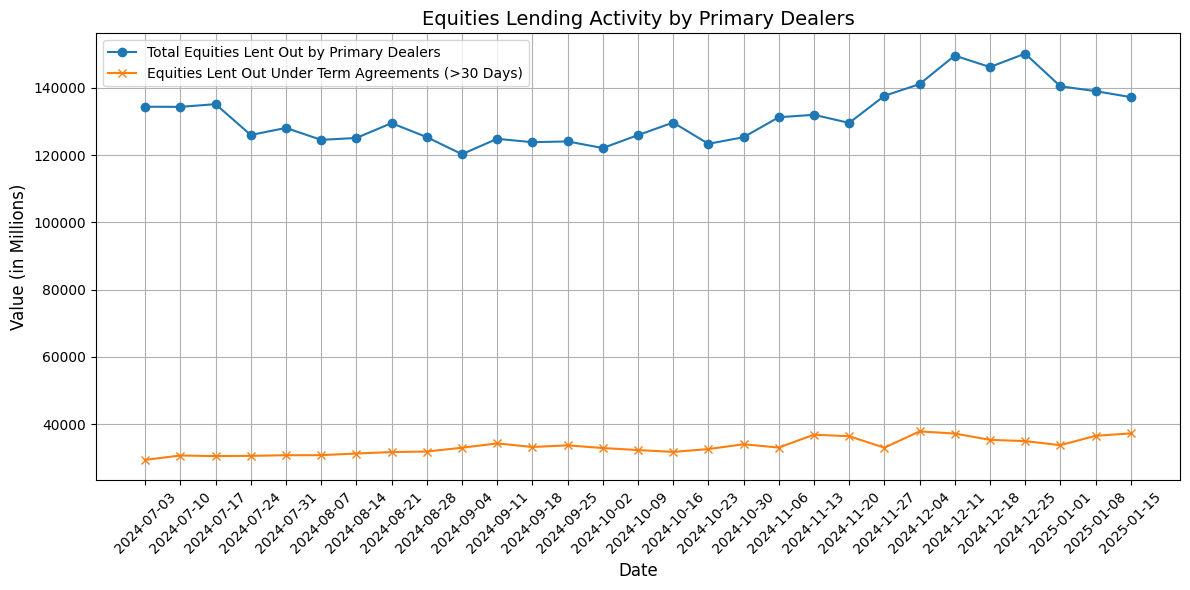

In [52]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Reference URLs (commented-out so Python doesn't treat them as code):
#   April 2013 to Dec 2014
#   https://markets.newyorkfed.org/api/pd/get/SBN2013/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.json
#
#   Jan 2015 to Dec 2021
#   https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.xlsx
#
#   Jan 2022 to Jun 2024
#   https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.json
#
#   June 2024 to today
#   https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSOOS-E_PDSOOS-ETAL30_PDSOOS-ETAG30.json
# ------------------------------------------------------------------

# Just pick the current URL you want to fetch:
api_url = "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSOOS-E_PDSOOS-ETAL30_PDSOOS-ETAG30.json"

# Fetch the data from the API
response = requests.get(api_url)
if response.status_code == 200:
    api_data = response.json()
else:
    print(f"Failed to fetch data: {response.status_code}")
    exit()

data = api_data

dates = []
total_equities = []
term_agreements = []

# Loop over the "timeseries" portion of the returned JSON
for entry in data["pd"]["timeseries"]:
    if entry["keyid"] == "PDSOOS-E":
        dates.append(entry["asofdate"])
        total_equities.append(int(entry["value"]))
    elif entry["keyid"] == "PDSOOS-ETAG30":
        term_agreements.append(int(entry["value"]))

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(dates, total_equities, label="Total Equities Lent Out by Primary Dealers", marker="o")
plt.plot(dates, term_agreements, label="Equities Lent Out Under Term Agreements (>30 Days)", marker="x")

# Customize the chart
plt.title("Equities Lending Activity by Primary Dealers", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (in Millions)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

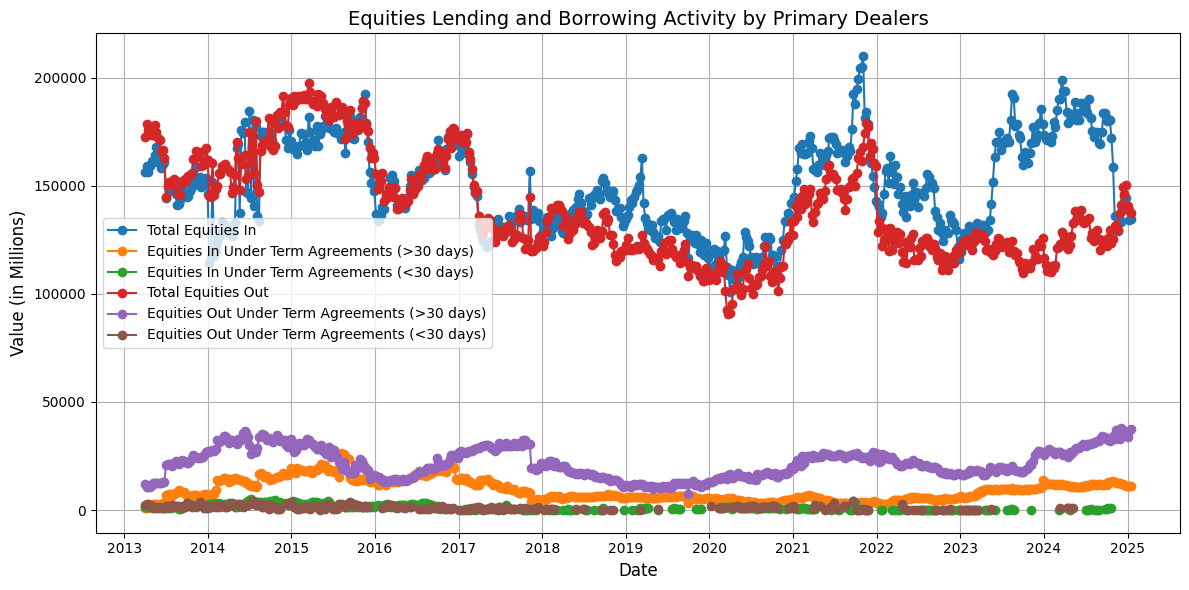

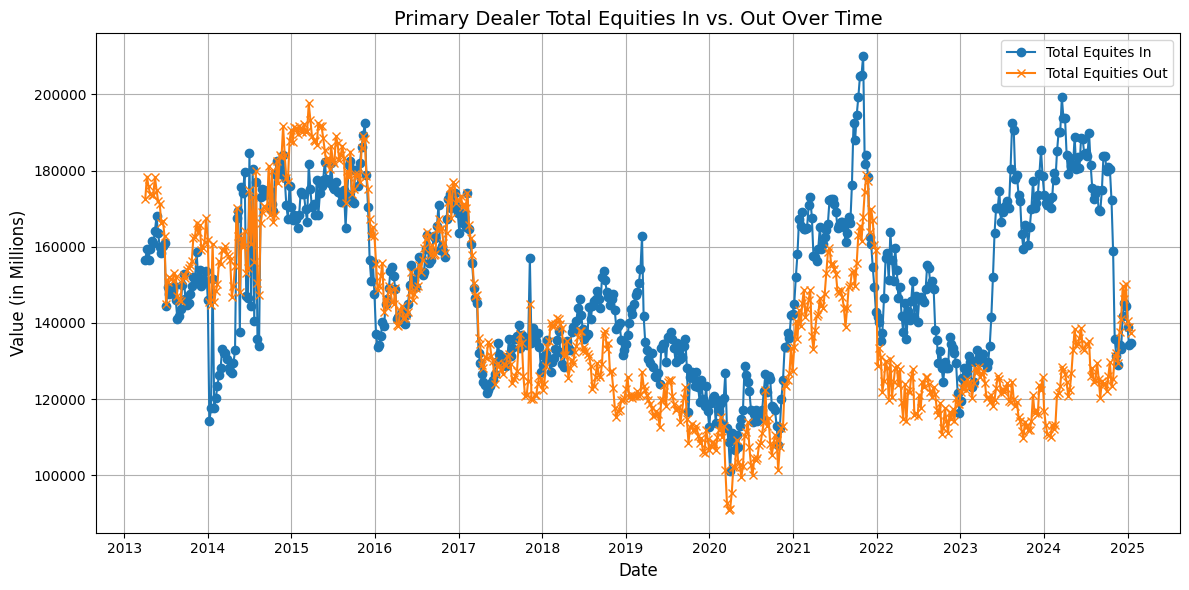

In [51]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# API URLs
urls = [
    # Securities In (Borrowed)
    "https://markets.newyorkfed.org/api/pd/get/SBN2013/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.json",
    "https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.json",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.json",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIOSB-E_PDSIOSB-ETAL30_PDSIOSB-ETAG30.json",
    # Securities Out (Lent)
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSOOS-E_PDSOOS-ETAL30_PDSOOS-ETAG30.json",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSOOS-E_PDSOOS-ETAL30_PDSOOS-ETAG30.json",
    "https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSOOS-E_PDSOOS-ETAL30_PDSOOS-ETAG30.json",
    "https://markets.newyorkfed.org/api/pd/get/SBN2013/timeseries/PDSOOS-E_PDSOOS-ETAL30_PDSOOS-ETAG30.json"
]

def fetch_data_from_url(url):
    """Fetch JSON data from the given URL and return a DataFrame."""
    response = requests.get(url)
    if response.status_code == 200:
        json_data = response.json()
        # Extract the timeseries data
        data = [
            {
                "date": entry["asofdate"],
                "keyid": entry["keyid"],
                "value": entry["value"] if entry["value"] != "*" else None
            }
            for entry in json_data["pd"]["timeseries"]
        ]
        return pd.DataFrame(data)
    else:
        print(f"Failed to fetch data from {url}, status code: {response.status_code}")
        return pd.DataFrame()

# Aggregate data from all URLs
all_data = pd.DataFrame()
for url in urls:
    df = fetch_data_from_url(url)
    all_data = pd.concat([all_data, df], ignore_index=True)

# Data cleaning
all_data["date"] = pd.to_datetime(all_data["date"])
all_data["value"] = pd.to_numeric(all_data["value"], errors="coerce")  # Convert "*" to NaN
all_data.dropna(subset=["value"], inplace=True)

# Pivot the data for visualization
pivot_data = all_data.pivot(index="date", columns="keyid", values="value")

# Rename columns for better understanding
pivot_data.rename(
    columns={
        "PDSIOSB-E": "Total Equities In",
        "PDSIOSB-ETAG30": "Equities In Under Term Agreements (>30 days)",
        "PDSIOSB-ETAL30": "Equities In Under Term Agreements (<30 days)",
        "PDSOOS-E": "Total Equities Out",
        "PDSOOS-ETAG30": "Equities Out Under Term Agreements (>30 days)",
        "PDSOOS-ETAL30": "Equities Out Under Term Agreements (<30 days)"
    },
    inplace=True,
)

# First Chart: All categories (as before)
plt.figure(figsize=(12, 6))
for column in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[column], label=column, marker="o")

# Customize the x-axis to show one year at a time
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set major ticks to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Customize the chart
plt.title("Equities Lending and Borrowing Activity by Primary Dealers", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (in Millions)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the first plot
plt.show()

# Second Chart: Total Securities In vs. Total Securities Out
plt.figure(figsize=(12, 6))
if "Total Equities In" in pivot_data.columns and "Total Equities Out" in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data["Total Equities In"], label="Total Equites In", marker="o")
    plt.plot(pivot_data.index, pivot_data["Total Equities Out"], label="Total Equities Out", marker="x")

# Customize the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Customize the chart
plt.title("Primary Dealer Total Equities In vs. Out Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (in Millions)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the second plot
plt.show()

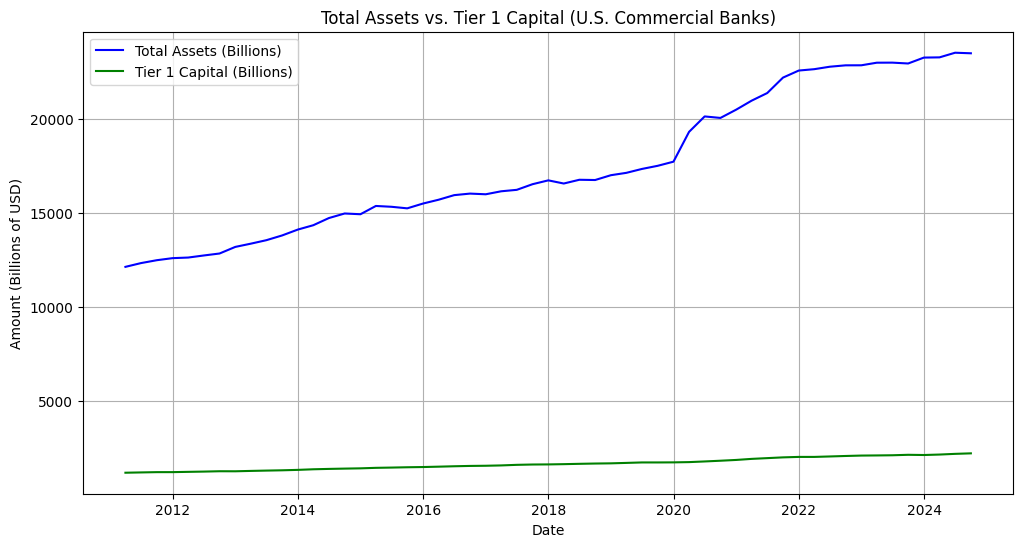

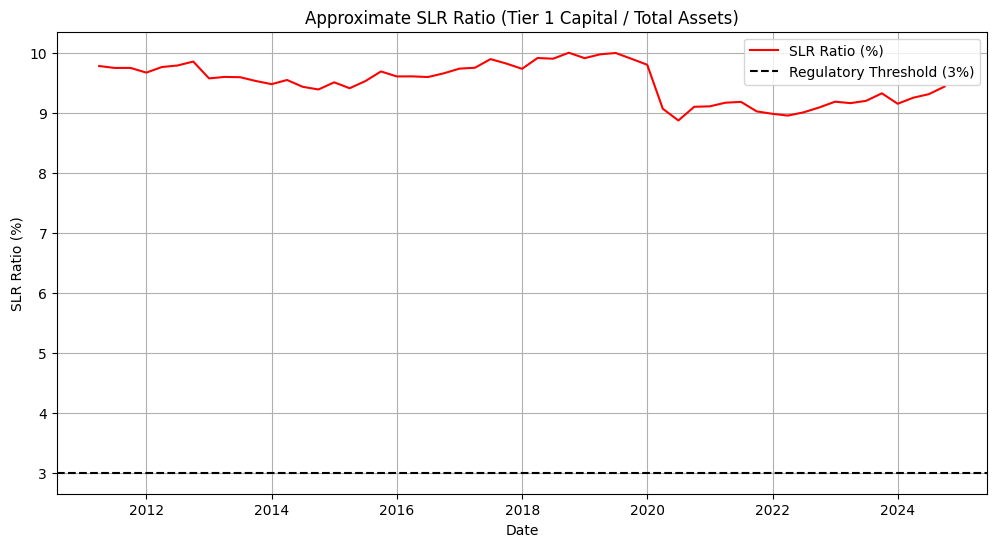

In [48]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Constants for the FRED API
FRED_API_KEY = 'b1b93f854d911b3cdc94df6dd9ec0365'  # Your FRED API key
TOTAL_ASSETS_SERIES_ID = 'TLAACBW027SBOG'  # Total Assets of All Commercial Banks series ID
BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'

# Path to the Tier 1 Capital data CSV
TIER_1_DATA_PATH = "../Data/Untitled 2.csv"

def fetch_fred_data(series_id, api_key):
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': '2011-01-01',  # Start date for data
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        observations = data['observations']
        dates = [obs['date'] for obs in observations]
        values = [float(obs['value']) for obs in observations]
        return pd.DataFrame({'Date': dates, 'Total Assets': values})
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

# Fetch Total Assets data (in Millions)
total_assets_data = fetch_fred_data(TOTAL_ASSETS_SERIES_ID, FRED_API_KEY)

# Load Tier 1 Capital data from CSV file
try:
    tier_1_data = pd.read_csv(TIER_1_DATA_PATH, header=0)
    tier_1_data = tier_1_data.iloc[:, :2]  # Keep only first two columns
    tier_1_data.columns = ["Date", "Tier 1 Capital"]  # Rename columns
    tier_1_data["Date"] = pd.to_datetime(tier_1_data["Date"].str.strip())
except FileNotFoundError:
    print(f"File not found: {TIER_1_DATA_PATH}")
    tier_1_data = None

if total_assets_data is not None and tier_1_data is not None:
    # Convert Date to pandas DateTime and set as index
    total_assets_data["Date"] = pd.to_datetime(total_assets_data["Date"])
    total_assets_data.set_index("Date", inplace=True)

    # Resample weekly data to quarterly, taking the last weekly observation each quarter
    quarterly_assets = total_assets_data.resample("QE").last().reset_index()

    # Merge on the quarter-end dates
    combined_data = pd.merge(
        quarterly_assets,
        tier_1_data,
        on="Date",
        how="inner"
    )

    
    # Convert millions → billions for the asset & capital amounts
    combined_data['Total Assets (Billions)'] = combined_data['Total Assets']
    combined_data['Tier 1 Capital (Billions)'] = combined_data['Tier 1 Capital'] / 1000.0

    # Calculate a "Leverage Ratio" ~ Tier 1 / Total Assets
    # (Note: True SLR includes off-balance sheet exposures, so this is an approximation)
    combined_data['SLR Ratio (%)'] = (combined_data['Tier 1 Capital (Billions)'] / combined_data['Total Assets (Billions)']) * 100 
    
    # ---------- Chart 1: Total Assets vs. Tier 1 Capital (both in Billions) ----------
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data['Date'], 
             combined_data['Total Assets (Billions)'],
             label='Total Assets (Billions)', color='blue')
    plt.plot(combined_data['Date'], 
             combined_data['Tier 1 Capital (Billions)'],
             label='Tier 1 Capital (Billions)', color='green')

    plt.xlabel('Date')
    plt.ylabel('Amount (Billions of USD)')
    plt.title('Total Assets vs. Tier 1 Capital (U.S. Commercial Banks)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- Chart 2: SLR Ratio (%) ----------
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data['Date'], 
             combined_data['SLR Ratio (%)'],
             label='SLR Ratio (%)', color='red')

    # Draw a horizontal 3% threshold line at y=3 (since the ratio is now in %)
    plt.axhline(y=3, color='black', linestyle='--', label='Regulatory Threshold (3%)')
    plt.xlabel('Date')
    plt.ylabel('SLR Ratio (%)')
    plt.title('Approximate SLR Ratio (Tier 1 Capital / Total Assets)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Unable to fetch or merge data. Ensure both FRED API and Tier 1 Capital data are accessible.")